In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
% matplotlib inline
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
data = sio.loadmat('annthyroid.mat') # dictionary

In [3]:
X = pd.DataFrame(data['X'])
X.columns=['feature 0','feature 1','feature 2','feature 3','feature 4','feature 5']
y = pd.DataFrame(data['y'])
y.columns = ['y']
df = pd.concat([X, y], axis=1)

# Task 1.1
## Univariate distributions of all features, jointly and per class

Text(0.5,1,'Class 1 Univariate Distributions')

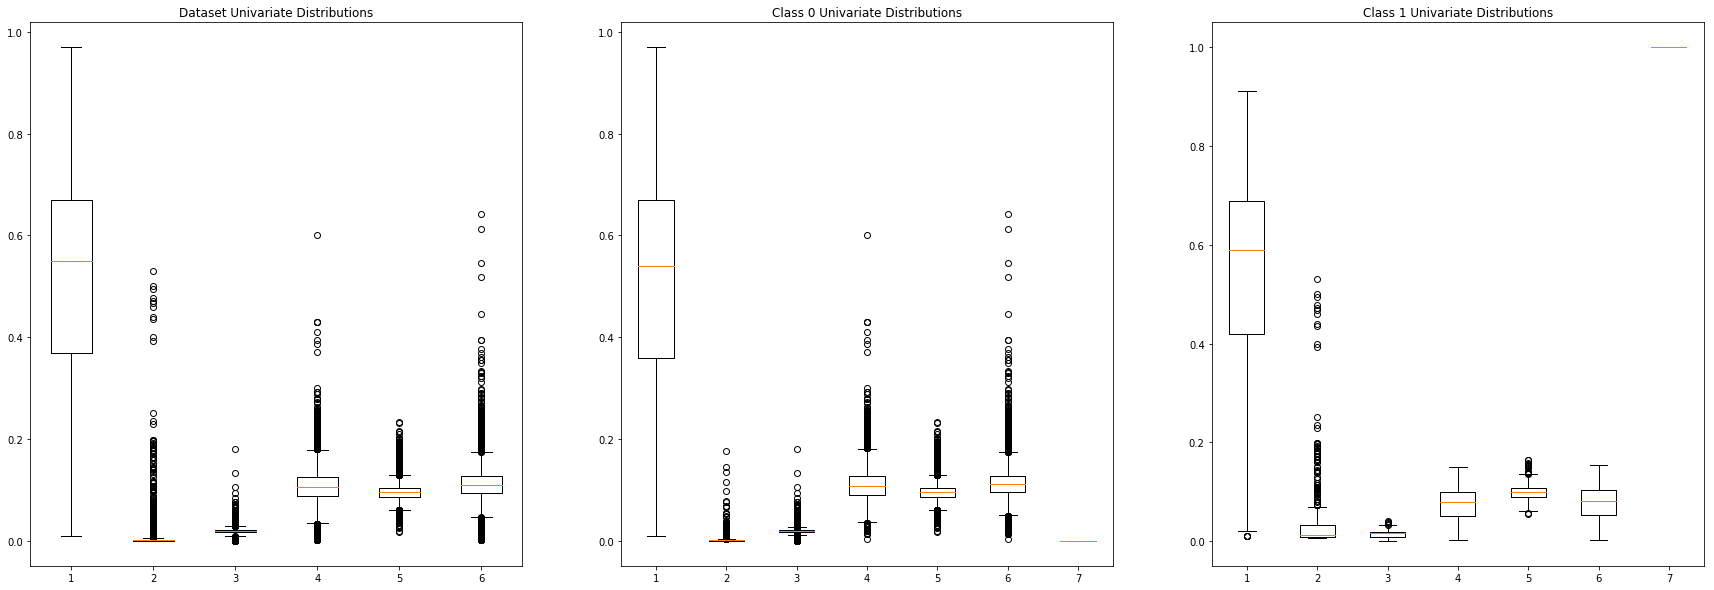

In [126]:
class_1 = df[df['y']==1]
class_0 = df[df['y']==0]
fig, axes = plt.subplots(1,3,figsize=(30,10))
axes[0].boxplot(X.T)
axes[0].set_title("Dataset Univariate Distributions")
# axes[0].xticks(np.arange(1,X.shape[1]+1),X.columns,rotation=30,ha='right')
axes[1].boxplot(class_0.T)
axes[1].set_title("Class 0 Univariate Distributions")
# axes[1].xticks(np.arange(1,X.shape[1]+1),X.columns,rotation=30,ha='right')
axes[2].boxplot(class_1.T)
axes[2].set_title("Class 1 Univariate Distributions")
# axes[2].xticks(np.arange(1,X.shape[1]+1),X.columns,rotation=30,ha='right')

In [117]:
def histogram(data):
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    feature_names = X.columns
    for i, ax in enumerate(axes.ravel()):
        feature = feature_names[i]
        ax.hist(X[feature])
        ax.set_title("{}".format(i))

### univariate distributions of all features

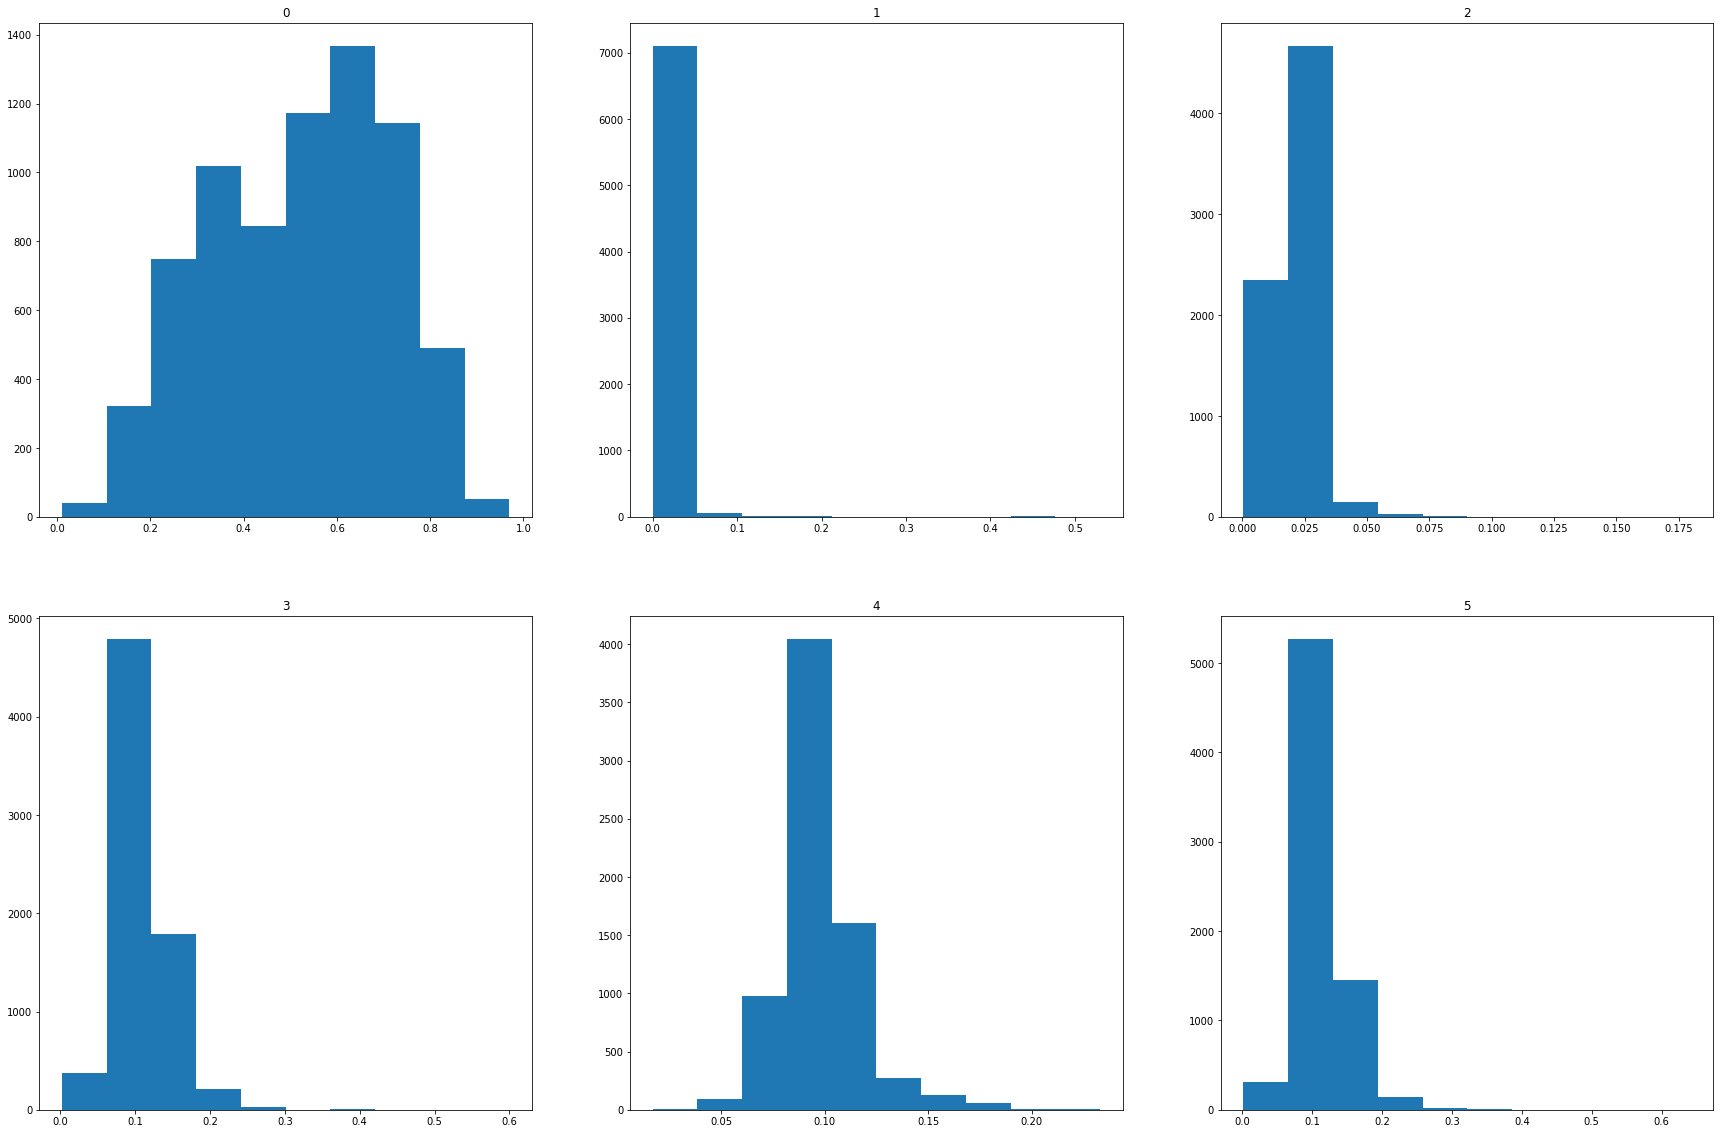

In [118]:
histogram(X)

### univariate distributions of class_0

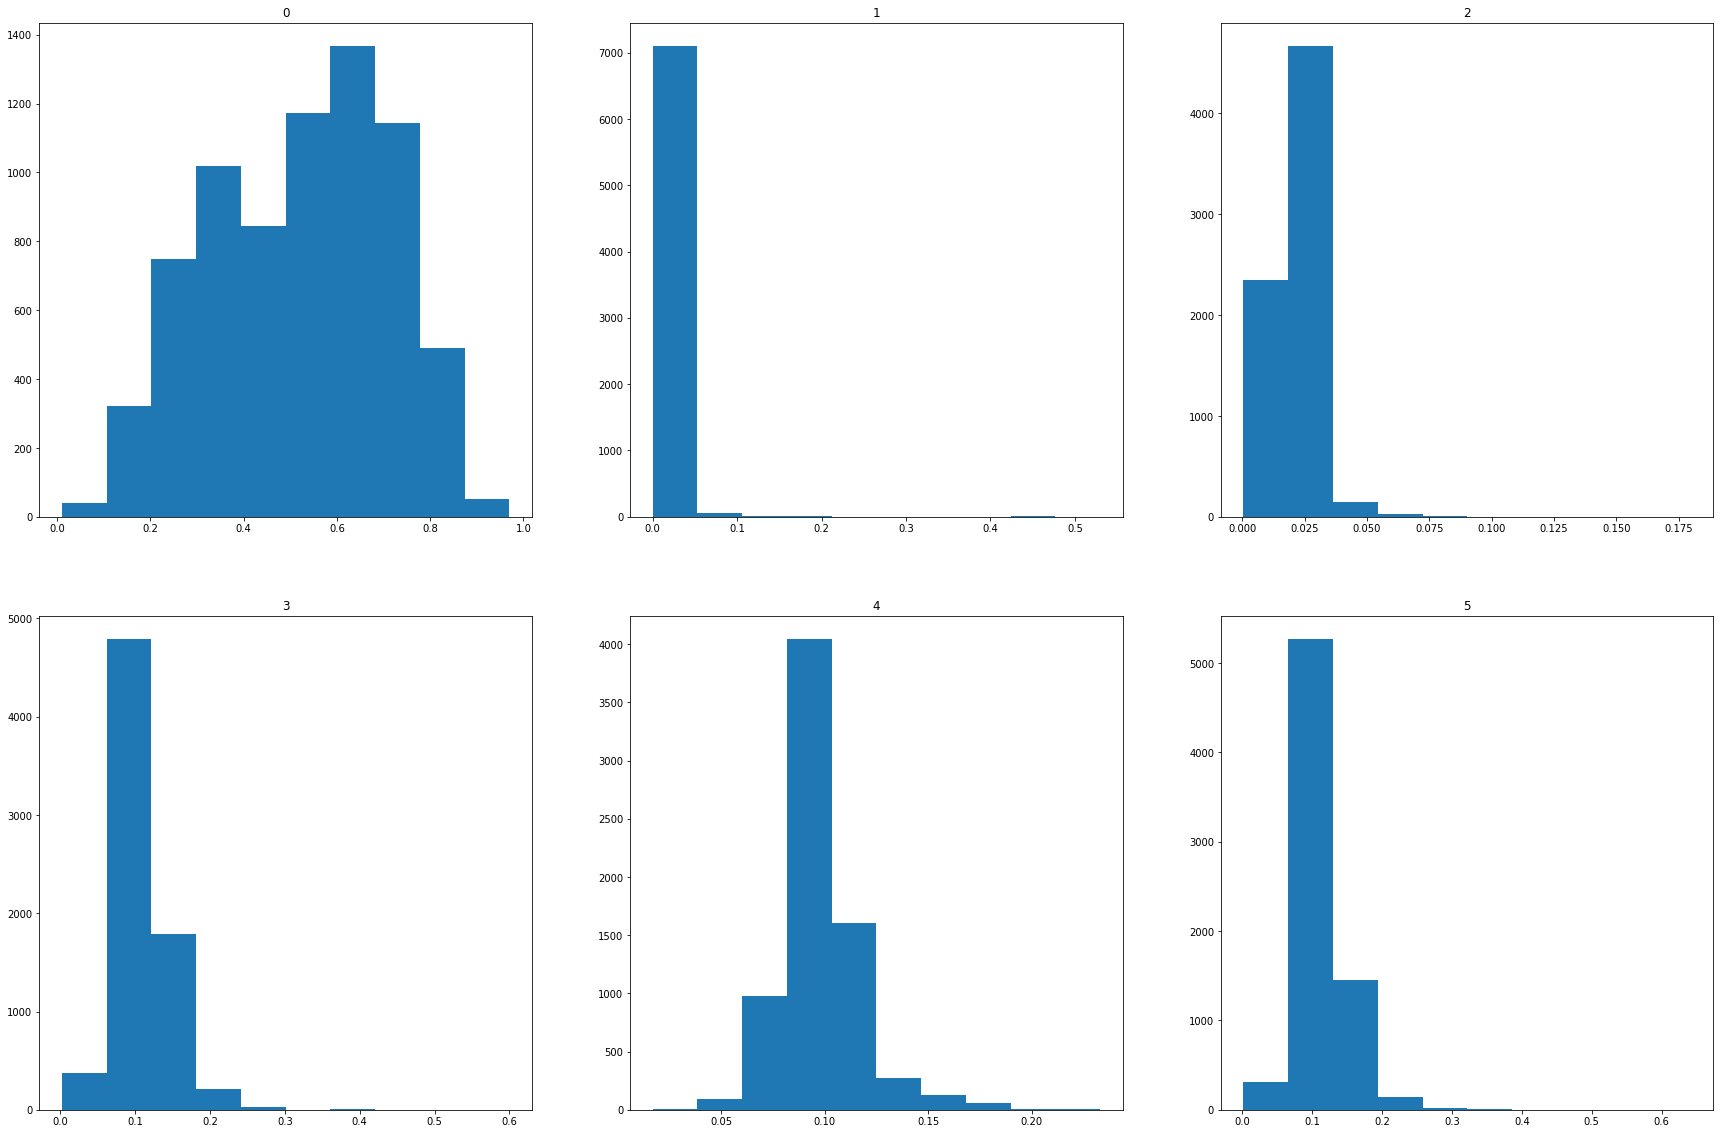

In [119]:
histogram(class_0)

### univariate distributions of class_1

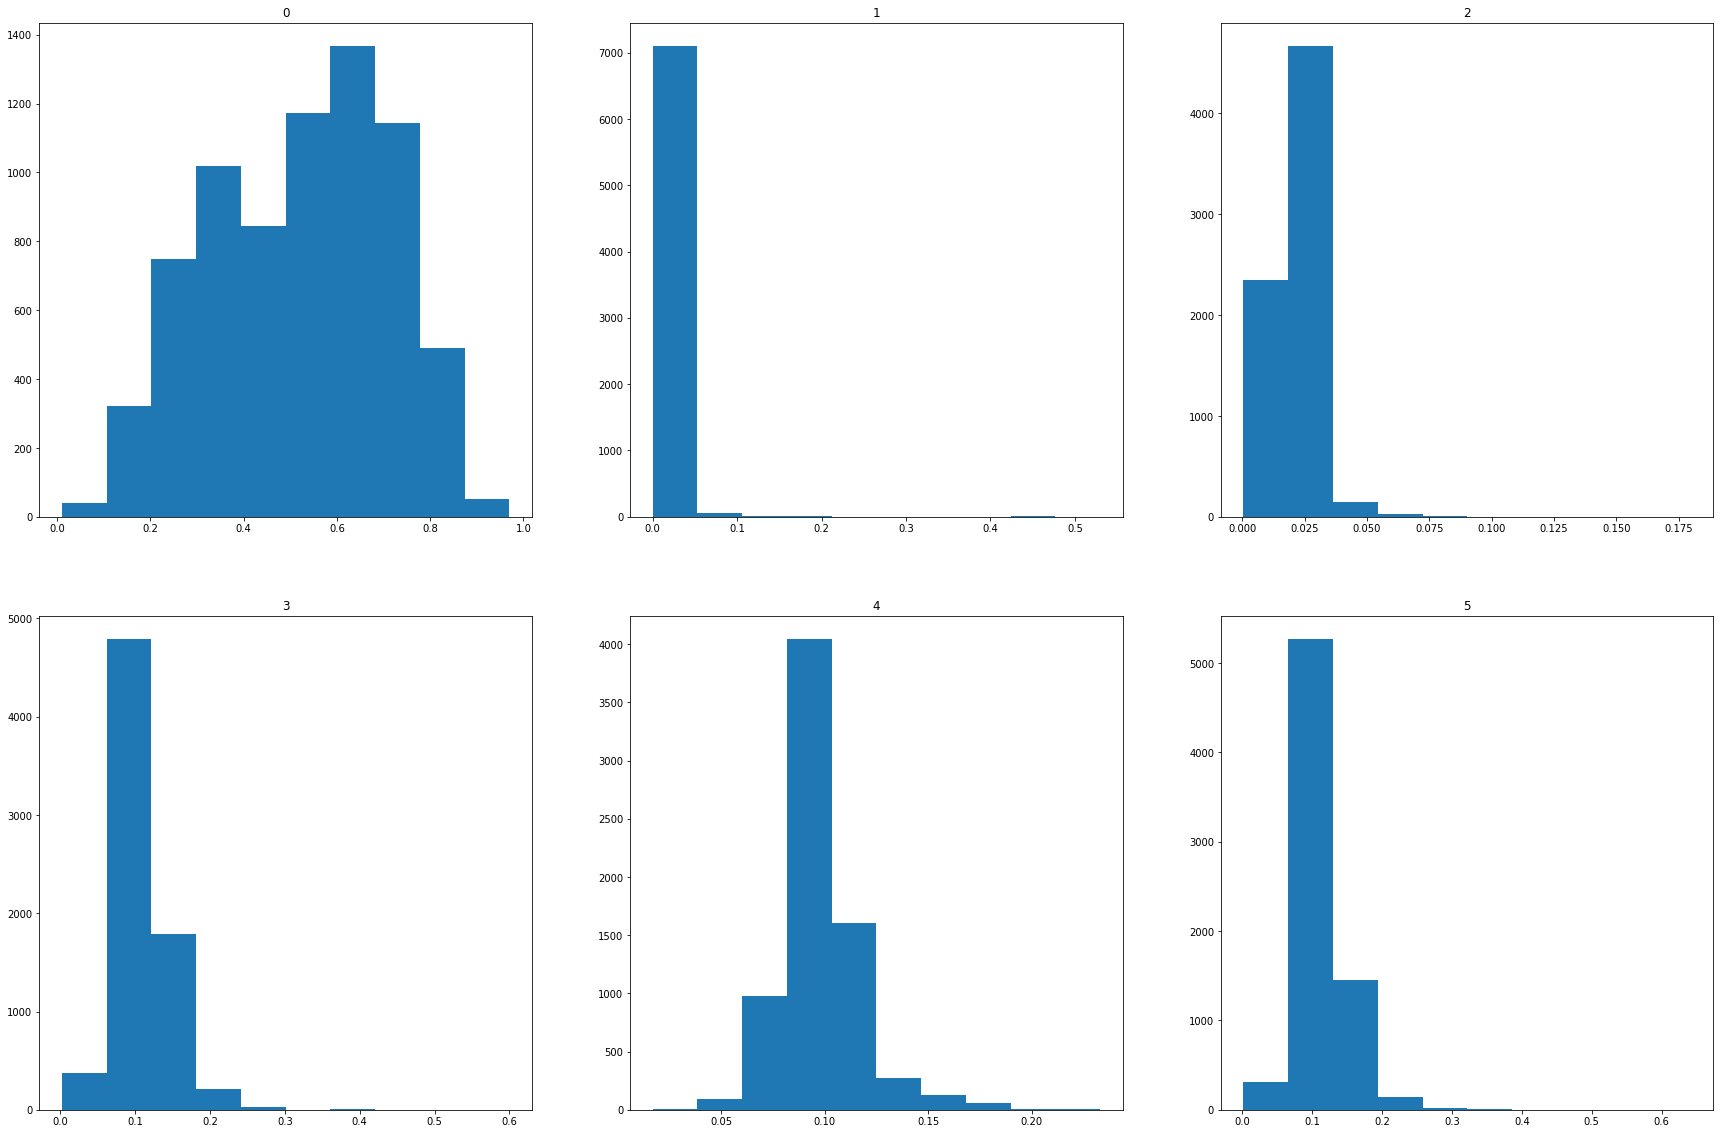

In [120]:
histogram(class_1)

## Visualize the data using PCA (first two principal components).

Text(0,0.5,'second principal component')

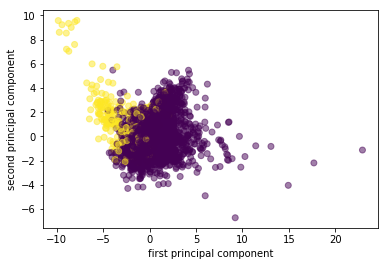

In [115]:
from sklearn.decomposition import PCA

pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=data['y'].flatten(), alpha=.5)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

### Plot the explained variance ratio in PCA.

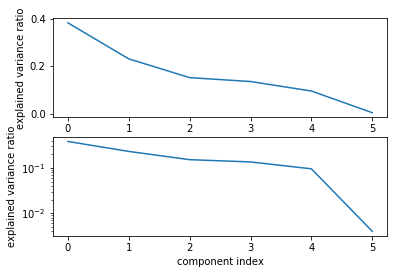

In [60]:
#Variance
pca_scaled = make_pipeline(StandardScaler(), PCA())
pca_scaled.fit(X, y)
pca = pca_scaled.named_steps['pca']

fig, axes = plt.subplots(2)
axes[0].plot(pca.explained_variance_ratio_)
axes[1].semilogy(pca.explained_variance_ratio_)
for ax in axes:
    ax.set_xlabel("component index")
    ax.set_ylabel("explained variance ratio")

### What would be a good threshold for the number of principal components if you wanted to reduce the dimensionality of the data to compress it?
According to the plot above 3 components might be a good number to cover the variance. 

# Task 1.2 Visualize the data using t-SNE.

In [ ]:
from sklearn.manifold import TSNE
for perplexity in [2, 5, 30]:
    plt.figure()
    plt.xticks(())
    plt.yticks(())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X_scaled)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=plt.cm.Vega10(data['y'].flatten()))
    plt.title("perplexity = {}".format(perplexity))

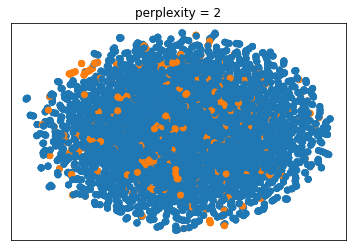

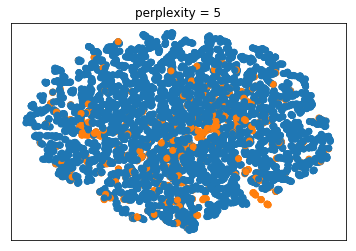

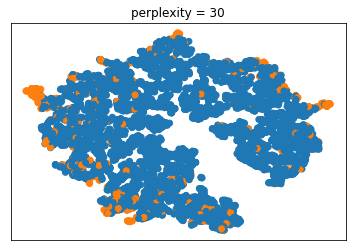

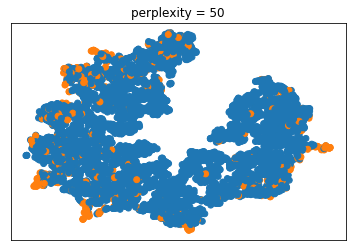

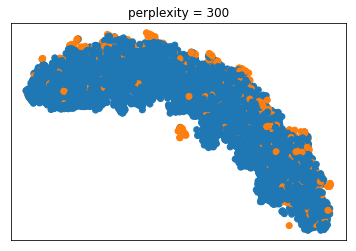

In [138]:
from sklearn.manifold import TSNE
for perplexity in [2, 5, 30, 50, 300]:
    plt.figure()
    plt.xticks(())
    plt.yticks(())
    # SCALE!!
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=plt.cm.Vega10(data['y'].flatten()))
    plt.title("perplexity = {}".format(perplexity))

### See if tuning the perplexity parameter helps obtaining a better visualization.
No. It does not help visualizing the dataset.

# Task 2

#### 2.1 Unsupervised Tunning 
+ Manual Parameter Tuning [Max/Min]
+ Manual Inspect
+ Semantic Interpretation [cluster mean explain]

In [4]:
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score
# function defined by professor Muller
def silhouette_plot(X, cluster_labels,silhouette_scores,ax=None):
    #silhouette_scores = silhouette_samples(X, cluster_labels)
    if ax is None:
        ax = plt.gca()
    y_lower = 10
    inliers = cluster_labels != -1
    X = X[inliers]
    cluster_labels = cluster_labels[inliers]
    silhouette_scores = silhouette_scores[inliers]
    labels = np.unique(cluster_labels)
    cm = plt.cm.Vega10 if len(labels) <= 10 else plt.cm.Vega20
    for i in labels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm(i)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

In [5]:
# Stability defined by professor Muller
from sklearn.base import clone
from sklearn.utils import check_random_state

def cluster_stability(X, est, n_iter=20, random_state=None):
    labels = []
    indices = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        est = clone(est)
        if hasattr(est, "random_state"):
            # randomize estimator if possible
            est.random_state = rng.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype=np.int)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            # we also compute the diagonal which is a bit silly
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

In [82]:
def truth_eval(alg,y): 
    print("adjusted_rand_score is {}".format(adjusted_rand_score(y,alg.labels_)))
    print("normalized_mutual_info_score is {}".format(normalized_mutual_info_score(y,alg.labels_)))
    print("adjusted_mutual_info_score is {}".format(adjusted_mutual_info_score(y, alg.labels_)))

### 1. K-Mean Clustering
    
    + Stability and silhouette [plot]
    + silhouette [visualization]

2:[4113 3087]
3:[2572 2418 2210]
4:[2208 1905 1724 1363]
5:[1791 1466 1431 1402 1110]
6:[1547 1422 1310 1159  896  866]
7:[1608 1421 1272 1088  892  746  173]
8:[1472 1346 1086 1035  878  742  487  154]
9:[1324 1195 1013 1002  940  656  492  418  160]


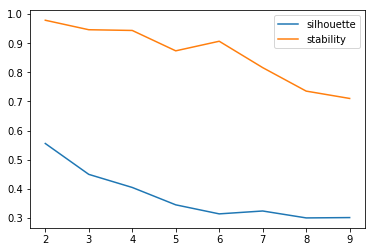

In [183]:
rng = np.random.RandomState(6)
X = data['X']
y = data['y'].flatten().astype(float)

sils,stability = [],[]
for i in range(2,10):
    km = KMeans(n_clusters=i) # not necessary to scale
    stability.append(cluster_stability(X, km))
    km.fit(X)
    print("{}:{}".format(i,np.sort(np.bincount(km.labels_))[::-1]))
    sils.append(silhouette_score(X, km.labels_))

plt.plot(range(2,10),sils, label="silhouette")
plt.plot(range(2,10),stability, label="stability")
plt.legend()

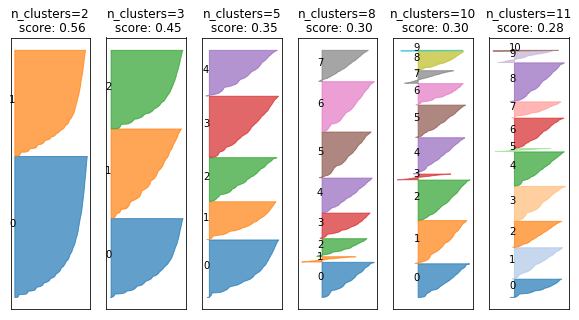

In [13]:
fig, axes = plt.subplots(1, 6, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
for ax, n_clusters in zip(axes, [2, 3, 5, 8, 10, 11]):
    km = KMeans(n_clusters=n_clusters)
    km.fit(data['X'])
    silhouette_scores = silhouette_samples(X, km.labels_)
    silhouette_plot(y, km.labels_,silhouette_scores, ax=ax)
    
    ax.set_title("n_clusters={}\n score: {:.2f}".format(n_clusters, silhouette_score(data['X'], km.labels_)))
    # print("n_clusters={}\n score: {:.2f}".format(n_clusters, silhouette_score(X, km.labels_)))

### manually tune the parameters for a reasonable outcome and document how you tuned the parameters.

Since the ground truth is binary classification, both stability and sihouette score is relatively high comparing with the rest and stability experiences a large drop after n_cluster = 2 and 3.
We also know that in practice the binary class is highly imbalanced, yet the class is very evenly distributed for n_clusters = 2 (see the cluster size result).
Thus, we prefer a n_cluster > 2 in hope of getting more close to ground truth's.
From the silhouette plot again we can see that n_cluster = 2 and 3 have the best cluster silhouette plot.

### Manual Inspect for n_cluster = 2 and 3

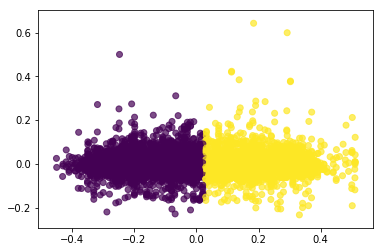

In [176]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)
km = KMeans(n_clusters=2).fit(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=.7)

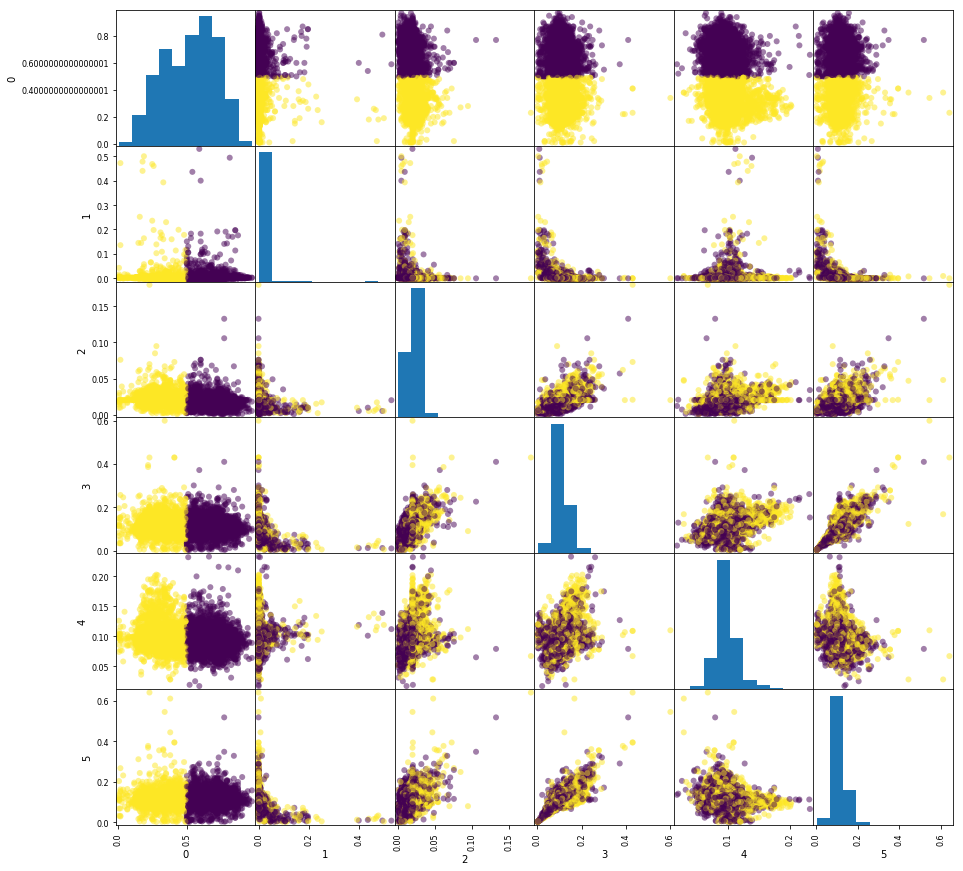

In [173]:
import pandas as pd
X_pd = pd.DataFrame(X)
# Create a scatter matrix from the dataframe, color by y_train
grr = pd.plotting.scatter_matrix(X_pd, c=km.labels_, figsize=(15, 15), marker='o')

### Manual Inspect for n_cluster = 3

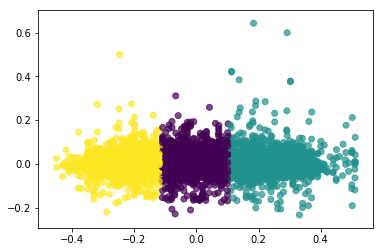

In [170]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X)
km = KMeans(n_clusters=3).fit(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=.7)

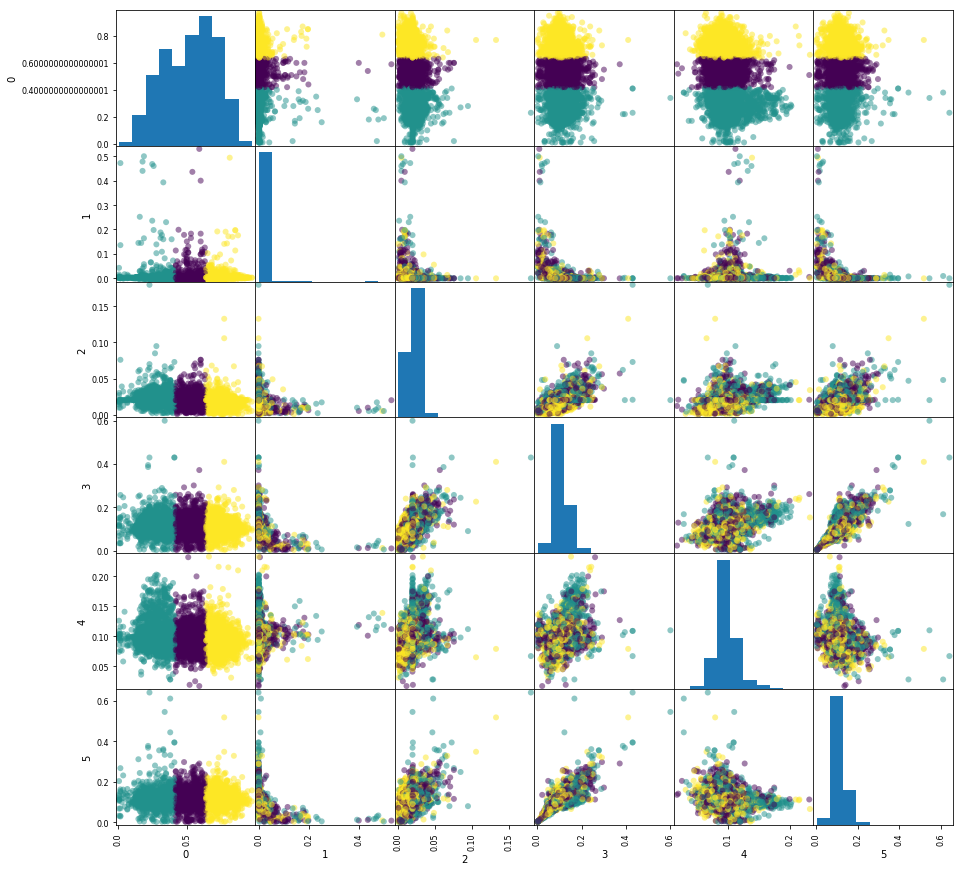

In [171]:
import pandas as pd
X_pd = pd.DataFrame(X)
# Create a scatter matrix from the dataframe, color by y_train
grr = pd.plotting.scatter_matrix(X_pd, c=km.labels_, figsize=(15, 15), marker='o')

No outlier detection successful. Obviously from the PCA plot, we can see that the three clusters is garthered together and the clustering devides relate to the main prnciple component, cut alone axis.

In [29]:
# Semantic Interpretation
km = KMeans(n_clusters=3).fit(X)
km.cluster_centers_

array([[0.73192308, 0.00429374, 0.0180896 , 0.10779237, 0.09486101,
        0.11491742],
       [0.29217014, 0.00531138, 0.02186428, 0.11291542, 0.10227214,
        0.11233626],
       [0.53678324, 0.00496189, 0.01996492, 0.10778791, 0.09653221,
        0.11249691]])

### 2. DBSCAN
        + Unsupervised
        due to the nature of DBSCAN 
        when espilon increase, stability and silouette value increase with number of cluster decrease.
        

In [194]:
rng = np.random.RandomState(6)
X = data['X']
y = data['y'].flatten().astype(float)
epses = np.logspace(-3, -.55, 10)

sils,stability = [],[]
for i in range(10):
    dbs = DBSCAN(eps=epses[i]) # not necessary to scale
    stability.append(cluster_stability(X, dbs))
    dbs.fit(X)
    sils.append(silhouette_score(X, dbs.labels_))
    print("{}:{}".format(i,np.sort(np.bincount(dbs.labels_+1))[::-1]))

0:[7133   10    9    7    6    6    6    6    6    6    5]
1:[7119   11    9    7    7    7    7    6    6    6    5    5    5]
2:[7070   12   10    9    8    8    7    7    6    6    6    6    5    5
    5    5    5    5    5    5    5]
3:[6263   24   20   20   19   19   17   17   17   16   16   15   14   14
   14   13   12   12   12   12   12   12   12   12   11   11   11   11
   11   11   11   10   10   10   10   10    9    9    9    9    9    9
    9    9    8    8    8    8    8    8    8    8    8    8    7    7
    7    7    7    7    7    7    7    7    6    6    6    6    6    6
    6    6    6    6    6    6    6    6    6    5    5    5    5    5
    5    5    5    5    5    5    5    5    5    5    5    5    5    5
    5    5    5    5    5    5    5    5    5    4    3]
4:[4509 2476   18    8    7    7    7    7    7    7    7    6    6    6
    6    6    6    5    5    5    5    5    5    5    5    5    5    5
    5    5    5    5    5    5    4    4    4    4    3]
5:[65

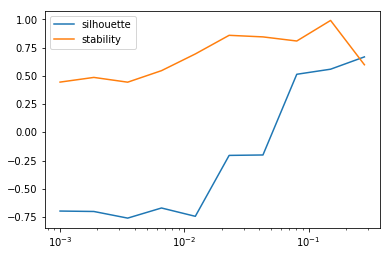

In [50]:
plt.plot(epses,sils, label="silhouette")
plt.xscale('log')
plt.plot(epses,stability, label="stability")
plt.legend()

when eps >= 0.3, only one clustering created with the rest marked as outliers.
Choose epsilon = 0.15058364, where its stability is maximized with a relatively high silhouette score.
We can see the size of the clusters is highly imbalanced, similar to the ground truth, for epsilon = 0.15058364

From the PCA plot in manual inspection, we are able to see the minority class and outliers (-1) are scattered around at the margin.

Text(0.5,1,'Scaled PCA')

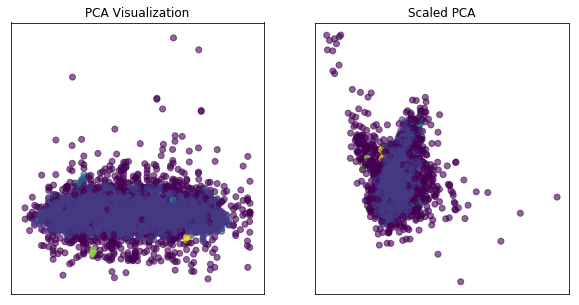

In [218]:
from sklearn.cluster import DBSCAN
X_pca = PCA(n_components=2).fit_transform(X)
eps = 0.021

from sklearn.decomposition import PCA
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
dbs = DBSCAN(eps=eps).fit(X)# max
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=dbs.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")

Text(0.5,1,'Scaled PCA')

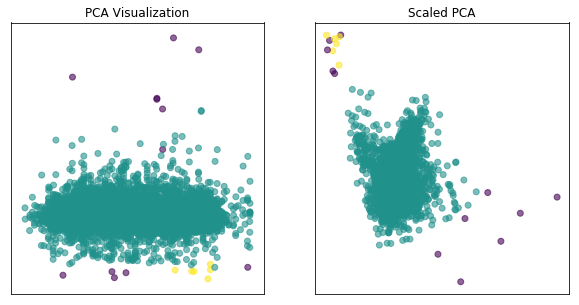

In [206]:
from sklearn.decomposition import PCA
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
dbs = DBSCAN(eps=0.15058364).fit(X)# max
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=dbs.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")
# truth_eval(dbs,y)


Scaled PCA visualization is better in detecting the cluster results and easier to differentiate outliers.

In [148]:
for i in range(len(set(dbs.labels_))):
    print("Number of class {} is {}".format(list(set(dbs.labels_))[i],count(dbs.labels_,list(set(dbs.labels_))[i],dbs)))

Number of class 0 is 7182
Number of class 1 is 6
Number of class -1 is 12


## 3. AgglomerativeClustering
    + From dendrogram, choose 5 clusters as the reasonable clusters number (for our imbalanced clustering purpose), since the distance to merge the two clusters is very large afterwards.
    + we observe that after n_cluster = 5 both stability and silhouette dropped very fast, so n_cluster = 5 is reasonble to choose.

In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X,'average')
dendrogram(linkage_matrix,truncate_mode="level",p=12,show_leaf_counts=True,leaf_rotation=60.,leaf_font_size=8.,show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

NameError: name 'X' is not defined

In [ ]:
from sklearn.neighbors import kneighbors_graph
rng = np.random.RandomState(6)
X = data['X']
y = data['y'].flatten().astype(float)

sils,stability = [],[]
for i in range(2,10):
    
    agg = AgglomerativeClustering(n_clusters=i, connectivity=lambda x: kneighbors_graph(x, 10),linkage ='average').fit(X) 
    stability.append(cluster_stability(X, agg))
    agg.fit(X)
    sils.append(silhouette_score(X, agg.labels_))
    print("{}:{}".format(i,np.sort(np.bincount(agg.labels_))[::-1]))

    
plt.plot(range(2,10),sils, label="silhouette")
plt.plot(range(2,10),stability, label="stability")
plt.legend()

2:[7198    2]


/Users/Selina/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


3:[7197    2    1]
4:[7193    4    2    1]


Text(0.5,1,'Scaled PCA')

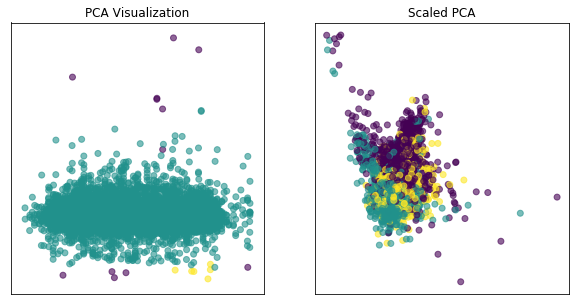

In [213]:
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg.fit(X)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=agg.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")

In [214]:
for i in range(len(set(agg.labels_))):
    print("Number of class {} is {}".format(list(set(agg.labels_))[i],count(agg.labels_,list(set(agg.labels_))[i],agg)))

Number of class 0 is 3177
Number of class 1 is 1989
Number of class 2 is 2034


Text(0.5,1,'Scaled PCA')

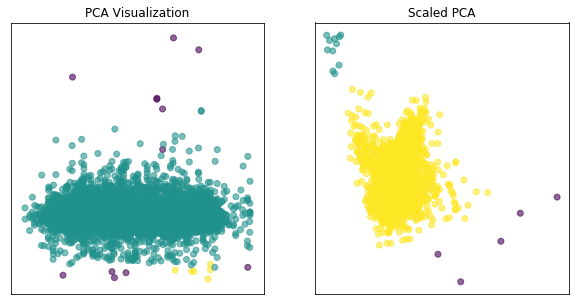

In [211]:
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=3, linkage='average')
agg.fit(X)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=agg.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")

fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg.fit(X)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=agg.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")

In [212]:
for i in range(len(set(agg.labels_))):
    print("Number of class {} is {}".format(list(set(agg.labels_))[i],count(agg.labels_,list(set(agg.labels_))[i],agg)))

Number of class 0 is 5
Number of class 1 is 11
Number of class 2 is 7184


PCA visualization is better in detecting the cluster results and easier to differentiate outliers.
When we change the linkage function from ward to average, the cluster size is more likely to be imbalanced and produce a better result in our case [imbalance problem].

## 2.2 Supervised

#### Kmeans

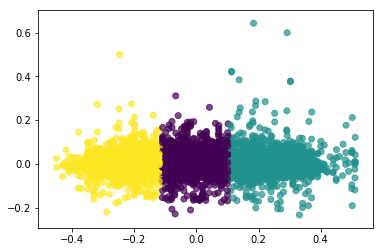

In [83]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X)
km = KMeans(n_clusters=3).fit(X)
km.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=.7)

In [84]:
truth_eval(km,y)

adjusted_rand_score is -0.00048814915111017543
normalized_mutual_info_score is 0.0019033080104905854
adjusted_mutual_info_score is 0.0008076160354303208


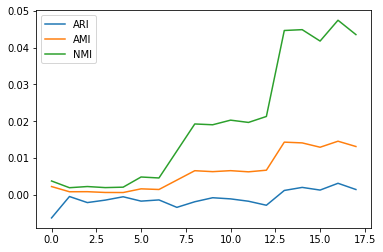

In [112]:
from sklearn.cluster import KMeans
y = data['y'].flatten().astype(float)

aris, nmis,amis,sils,stability = [],[],[],[],[]
for i in range(2,20):
    km = KMeans(n_clusters=i) # not necessary to scale
    km.fit(X)
    aris.append(adjusted_rand_score(y, km.labels_))
    nmi = normalized_mutual_info_score(y,km.labels_)
    ami = adjusted_mutual_info_score(y, km.labels_)
    nmis.append(nmi)
    amis.append(ami)
    
    
plt.plot(aris, label="ARI")
plt.plot(amis, label="AMI")
plt.plot(nmis, label="NMI")
# cluster size

plt.legend()

#### choose n_cluster = 13, as it has the relatively largest improvement with AMI and NMI scores, comparing with n_cluster =12.
select graph peak

In [168]:
  km = KMeans(n_clusters=13).fit(X)
km.cluster_centers_

array([[0.17266807, 0.00417716, 0.02150966, 0.11041588, 0.10006092,
        0.11140603],
       [0.56067708, 0.00575952, 0.01902531, 0.09289738, 0.09470582,
        0.09929331],
       [0.36457895, 0.00329325, 0.02033908, 0.09596358, 0.09701842,
        0.10038545],
       [0.73061224, 0.00462571, 0.01749194, 0.09515745, 0.09451343,
        0.10165496],
       [0.38167665, 0.00136662, 0.02528952, 0.15663174, 0.10873353,
        0.14919913],
       [0.46613358, 0.00481228, 0.01952586, 0.0991026 , 0.0963652 ,
        0.10364232],
       [0.70994286, 0.00143057, 0.02159886, 0.1542    , 0.09827429,
        0.16058334],
       [0.82621457, 0.00642937, 0.01608158, 0.10452289, 0.09203036,
        0.11504134],
       [0.313     , 0.32715   , 0.009425  , 0.022925  , 0.11385   ,
        0.020056  ],
       [0.63839104, 0.00365272, 0.01868941, 0.10258575, 0.09565988,
        0.10815533],
       [0.27142119, 0.00305487, 0.02176253, 0.11295522, 0.10616021,
        0.1076616 ],
       [0.55958515, 0

adjusted_rand_score is -0.0017597567565310044
normalized_mutual_info_score is 0.020902583568625756
adjusted_mutual_info_score is 0.0066417629176102186


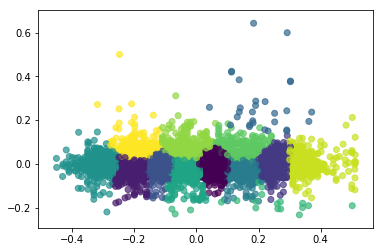

In [169]:
X_pca = PCA(n_components=2).fit_transform(X)
km = KMeans(n_clusters=13).fit(X)
km.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=.7)
truth_eval(km,y)

#### DBSCAN

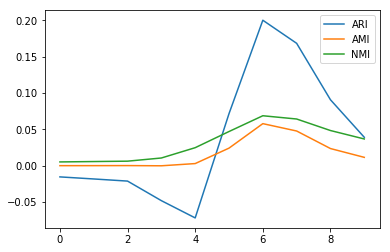

In [174]:
y = data['y'].flatten().astype(float)
# with respect to ground truth
# DB
aris, nmis,amis = [],[],[]
epses = np.logspace(-3, -1, 10)
for i in range(10):
    dbs = DBSCAN(eps=epses[i]).fit(X) # not necessary to scale
    ari = adjusted_rand_score(y,dbs.labels_)
    nmi = normalized_mutual_info_score(y,dbs.labels_)
    ami = adjusted_mutual_info_score(y, dbs.labels_)
    aris.append(ari)
    nmis.append(nmi)
    amis.append(ami)
    
plt.plot(aris, label="ARI")
plt.plot(amis, label="AMI")
plt.plot(nmis, label="NMI")
plt.legend()


Choose epsilon 0.021544 so that ARI, AMI, NMI is at maximum

In [213]:
np.logspace(-3, -1, 10)[6]

0.021544346900318832

adjusted_rand_score is 0.0323999292322349
normalized_mutual_info_score is 0.04128362746989493
adjusted_mutual_info_score is 0.010524588809546993


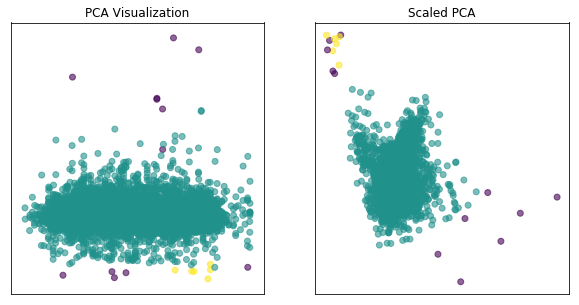

In [217]:
# Manual Inspect
from sklearn.decomposition import PCA
fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
dbs = DBSCAN(eps=0.15058364).fit(X)# max
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbs.labels_, alpha=.6)
axes[0].set_title("PCA Visualization")
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=dbs.labels_, alpha=.6)
axes[1].set_title("Scaled PCA")
truth_eval(dbs,y)

Outlier Detection: 
the number of ylabel = 1 is the same as DBScan

#### AgglomerativeClustering

Text(0.5,1,'Scaled PCA')

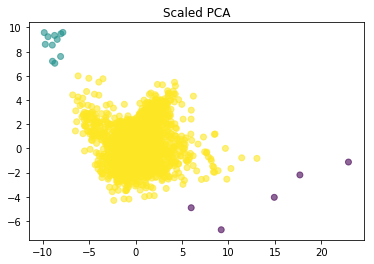

In [221]:
# fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=3, linkage='average')
agg.fit(X)

plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=agg.labels_, alpha=.6)
plt.title("Scaled PCA")

In [222]:
truth_eval(agg,y)

adjusted_rand_score is 0.03301943591562745
normalized_mutual_info_score is 0.05998624904722752
adjusted_mutual_info_score is 0.014747187938794488


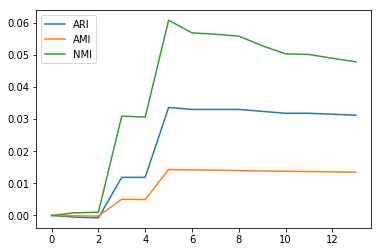

In [224]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

y = data['y'].flatten().astype(float)
# with respect to ground truth
# agg
aris, nmis,amis = [],[],[]

for i in range(1,15):
    agg = AgglomerativeClustering(n_clusters=i, connectivity=lambda x: kneighbors_graph(x, 10),linkage='average').fit(X)
    ari = adjusted_rand_score(y,agg.labels_)
    nmi = normalized_mutual_info_score(y,agg.labels_)
    ami = adjusted_mutual_info_score(y, agg.labels_)
    aris.append(ari)
    nmis.append(nmi)
    amis.append(ami)
    
plt.plot(aris, label="ARI")
plt.plot(amis, label="AMI")
plt.plot(nmis, label="NMI")
plt.legend()

Pick the n_cluster=5 with the highest NMI and AMI score.

Text(0.5,1,'Scaled PCA')

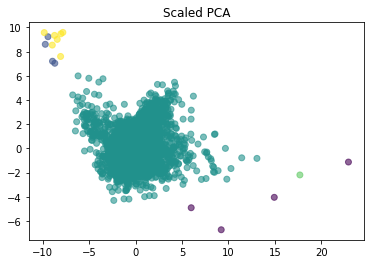

In [225]:
# fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
X_pca=PCA(n_components=2).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=5, linkage='average')
agg.fit(X)

plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=agg.labels_, alpha=.6)
plt.title("Scaled PCA")

### How well did they do? Can you adjust parameters so they can detect the outliers better?

Very nice.

we see that on n_cluster = 3, there is indded a sudden increment in all supervised metrics yet the metrics value is still small, comparing with n_cluster = 11.

